## Time Series Forecasting Multivariato con Bike Sharing Demand

**_Scopo dell’analisi:_**  
Predire la domanda futura di biciclette (prossima ora), usando una finestra temporale passata (ultime 24 ore) e le caratteristiche meteo e temporali.  

**_Modelli utilizzati:_**  
CNN 1D, LSTM, GRU.  

**_Obiettivi finali:_**  
Confronto tra modelli e scelta del migliore.  

Fonte: [kaggle.com](https://www.kaggle.com/competitions/bike-sharing-demand/data)

## Import delle librerie necessarie

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import json
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [3]:
from utils.seed_utils import set_seed
set_seed(42)

## Import dataset

**Datetime** - hourly date + timestamp   
**Season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
**Holiday** - whether the day is considered a holiday  
**Workingday** - whether the day is neither a weekend nor holiday   
**Weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy;
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist;
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds;
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**Temp** - temperature in Celsius   
**Atemp** - "feels like" temperature in Celsius   
**Humidity** - relative humidity   
**Windspeed** - wind speed   
**Casual** - number of non-registered user rentals initiated   
**Registered** - number of registered user rentals initiated   
**Count** - number of total rentals   

In [4]:
df = pd.read_csv("./data/raw/data.csv")

## Analisi dataset

In [5]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [8]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


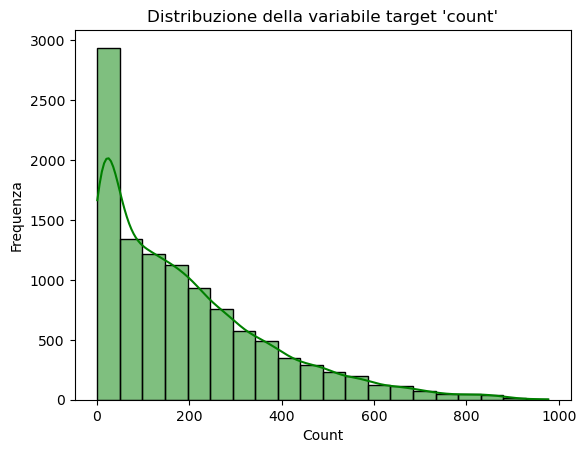

In [9]:
sns.histplot(data=df, x='count', kde=True, bins=20, color="green")
plt.title("Distribuzione della variabile target 'count'")
plt.xlabel("Count")
plt.ylabel("Frequenza")
plt.show()

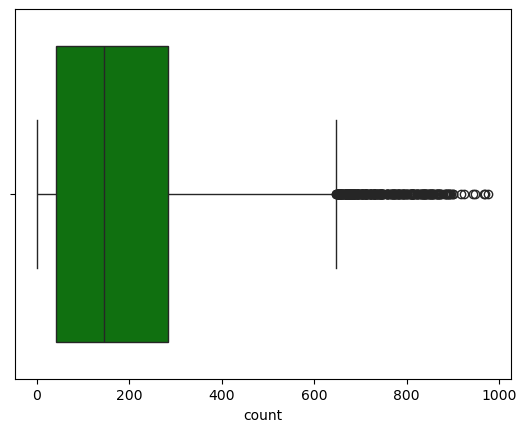

In [10]:
sns.boxplot(data=df, x='count', color='green')
plt.show()

## Preprocessing

In [11]:
# Drop colonne inutili
df = df.drop(columns=["casual", "registered", "atemp"])

In [12]:
# parsing datetime
df["datetime"] = pd.to_datetime(df["datetime"])

df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

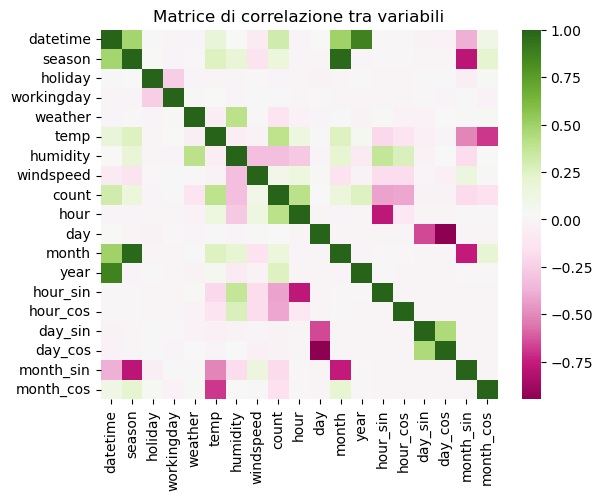

In [13]:
sns.heatmap(df.corr(), cmap='PiYG')
plt.title("Matrice di correlazione tra variabili")
plt.show()

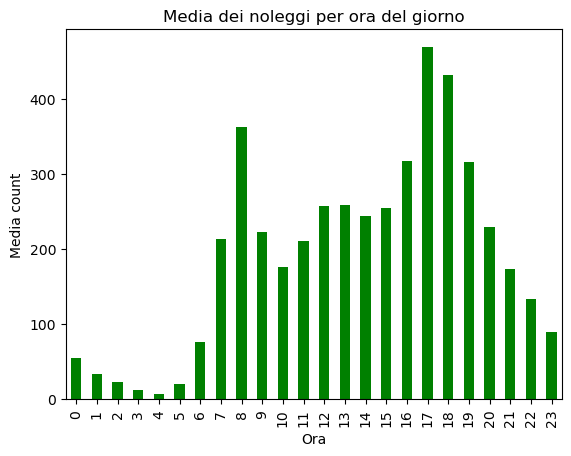

In [14]:
df.groupby("hour")["count"].mean().plot(kind='bar', color='green')
plt.title("Media dei noleggi per ora del giorno")
plt.xlabel("Ora")
plt.ylabel("Media count")
plt.show()

In [15]:
# Drop colonne ridondanti
df = df.drop(columns=["datetime", "hour", "day", "month"])

In [16]:
# One-hot encoding (season e weather)

season_map = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
weather_map = {1: 'clear', 2: 'mist', 3: 'light_mix', 4: 'heavy_mix'}

df['season'] = df['season'].map(season_map)
df['weather'] = df['weather'].map(weather_map)

categorical_cols = ['season', 'weather']

encoder = OneHotEncoder(sparse_output=False, drop=None)

encoded = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)

df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

In [17]:
df.head()

,holiday,workingday,temp,humidity,windspeed,count,year,hour_sin,hour_cos,day_sin,...,month_sin,month_cos,season_fall,season_spring,season_summer,season_winter,weather_clear,weather_heavy_mix,weather_light_mix,weather_mist
0,0,0,9.84,81,0.0,16,2011,0.000000,1.000000,0.201299,...,0.5,0.866025,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,9.02,80,0.0,40,2011,0.258819,0.965926,0.201299,...,0.5,0.866025,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,9.02,80,0.0,32,2011,0.500000,0.866025,0.201299,...,0.5,0.866025,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0,9.84,75,0.0,13,2011,0.707107,0.707107,0.201299,...,0.5,0.866025,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,9.84,75,0.0,1,2011,0.866025,0.500000,0.201299,...,0.5,0.866025,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
# Log trasformazione della colonna 'count'
df['count'] = np.log1p(df['count'])

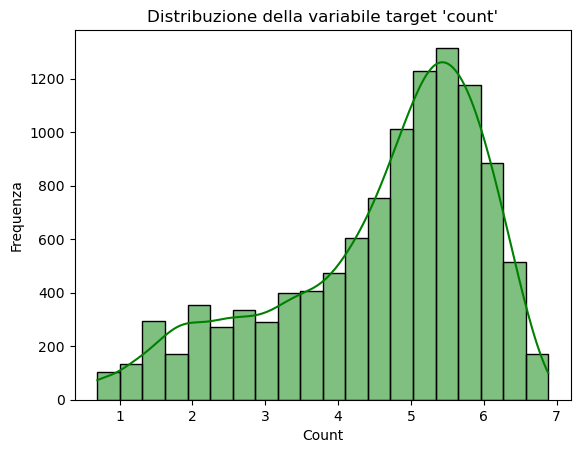

In [19]:
sns.histplot(data=df, x='count', kde=True, bins=20, color="green")
plt.title("Distribuzione della variabile target 'count'")
plt.xlabel("Count")
plt.ylabel("Frequenza")
plt.show()

In [20]:
# Suddivisione temporale train/val/test (70% - 15% - 15%)
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

In [21]:
# Normalizzazione
cols_to_scale = [
    'temp', 'humidity', 'windspeed', 'year',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'month_sin', 'month_cos'
]

scaler_features = MinMaxScaler()
scaler_features.fit(train_df[cols_to_scale])

train_df[cols_to_scale] = scaler_features.transform(train_df[cols_to_scale])
val_df[cols_to_scale]   = scaler_features.transform(val_df[cols_to_scale])
test_df[cols_to_scale]  = scaler_features.transform(test_df[cols_to_scale])

scaler_target = MinMaxScaler()
scaler_target.fit(train_df[['count']])

train_df['count'] = scaler_target.transform(train_df[['count']])
val_df['count']   = scaler_target.transform(val_df[['count']])
test_df['count']  = scaler_target.transform(test_df[['count']])

joblib.dump(scaler_target, "scaler_target.pkl");

In [22]:
# salvataggio dataset processati
train_df.to_csv("data/processed/train.csv", index=False)
test_df.to_csv("data/processed/test.csv", index=False)
val_df.to_csv("data/processed/val.csv", index=False)

## Modellazione

### Scelta dei Modelli
Per affrontare il problema sono stati implementati e confrontati 3 modelli di rete neurale:

_CNN1D:_ adatta a catturare pattern locali nei dati temporali.

_LSTM:_ efficace per sequenze con dipendenze a lungo termine.

_GRU:_ variante semplificata delle LSTM, con prestazioni comparabili ma maggiore efficienza.

Queste reti sono implementate come moduli PyTorch nei file: models/cnn1d_model.py, models/lstm_model.py, models/gru_model.py.

La scelta è ricaduta su questi modelli per la loro efficacia nel modellare dati sequenziali e per permettere un confronto tra architetture convoluzionali e ricorrenti.

### Configurazione dell’Addestramento
L’addestramento dei modelli è gestito da una classe `Trainer`, contenuta nel file _trainer.py_. I parametri di configurazione sono caricati dinamicamente da un file Json (_config.json_), che permette di cambiare facilmente rete e iperparametri senza modificare il codice sorgente.

I principali iperparametri utilizzati sono:

- batch_size = 32
- window_size = 24
- learning_rate = 0.005
- momentum	= 0.9
- epochs = 100
- loss_target = 0.001
- optimizer	= Adam
- loss_function	= MSELoss
- early_stop_patience = 15

### Strategia di Addestramento
L'addestramento segue questi passaggi:

1. **Costruzione del modello** secondo il tipo specificato.

2. **Inizializzazione** di ottimizzatore e funzione di loss.

3. **Addestramento su epoche multiple** con monitoraggio della loss sul set di validazione.

4. **Early stopping** se la validation loss non migliora oltre un certo margine per un numero di epoche consecutive, l’addestramento viene interrotto.

5. **Salvataggio dei modelli:**

    - best_model.pth: il migliore raggiunto in validazione.

    - last_model.pth: quello dell’ultima epoca completata.


Durante il training, è possibile **caricare l’ultimo modello** salvato (_reload_last_model: True_) per riprendere da dove si era interrotto.

### Sperimentazione
È stato condotto un processo iterativo di sperimentazione sull’architettura del modello, sugli iperparametri e sulle tecniche di regolarizzazione, con l’obiettivo di ottimizzare le prestazioni sui dati di test.

Tutti i dettagli (log, metriche, configurazioni) sono documentati nella cartella `experiments/`.  

**Obiettivi**  
- Migliorare la capacità predittiva del modello, in particolare minimizzando MSE e MAPE.

- Esplorare diverse combinazioni di architetture e iperparametri.

- Valutare l’impatto di singole scelte progettuali (ottimizzatore, profondità, dropout, ecc.).

**Considerazioni principali**   
- _**Ottimizzatore – da SGD ad Adam:**_ il passaggio si è rivelato cruciale per ottenere una convergenza più rapida e stabile durante l’addestramento.

- _**Learning rate:**_ piccole variazioni (es. da 0.001 a 0.0005) hanno influenzato significativamente l’accuratezza in validazione.

- _**Profondità del modello (num layers):**_ un numero maggiore di layer ha incrementato la capacità di modellazione, specialmente nei modelli ricorrenti.

- _**Hidden size:**_ l’aumento da 64 a 256 ha migliorato le prestazioni, grazie a una maggiore capacità rappresentativa.

- _**Dropout:**_ l’uso di valori più elevati (fino a 0.3) ha contribuito a ridurre l’overfitting, favorendo una migliore generalizzazione.

- _**Batch Normalization (CNN):**_ l’introduzione della normalizzazione ha reso l’addestramento più stabile e veloce.

- _**Pooling combinato (CNN):**_ la concatenazione di average pooling e max pooling ha permesso un’estrazione più robusta delle caratteristiche sequenziali.

## Valutazione e Confronto dei Modelli

Dopo una fase estesa di sperimentazione, sono stati confrontati tre modelli principali: **CNN 1D**, **GRU**, e **LSTM**.  
L'obiettivo era valutare la loro efficacia nel compito di forecasting, utilizzando diverse metriche di regressione su dati di test.  

### Metriche di valutazione

In [28]:
data = {
    "Model": ["LSTM", "GRU", "CNN-1D"],
    "MSE": [0.193, 0.234, 0.498],
    "RMSE": [0.440, 0.484, 0.706],
    "MAE": [0.343, 0.369, 0.545],
    "MAPE (%)": [8.47, 9.12, 14.35],
    "Early Stopping (epoch)": [29, 32, 66]
}

df_metrics = pd.DataFrame(data)

styled_df = df_metrics.style \
    .format({ "MSE": "{:.3f}", "RMSE": "{:.3f}", "MAE": "{:.3f}", "MAPE (%)": "{:.2f}"
    }) \
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "110%"), ("min-width", "100px"), ("max-width", "120px"), ("text-align", "center")]},
        {"selector": "td", "props": [("font-size", "105%"), ("min-width", "100px"), ("max-width", "120px"), ("text-align", "center")]}
    ]) \
    .hide(axis="index") \
    .background_gradient(subset=["MSE", "RMSE", "MAE", "MAPE (%)"], cmap='Greens')

styled_df

Model,MSE,RMSE,MAE,MAPE (%),Early Stopping (epoch)
LSTM,0.193,0.440,0.343,8.47,29
GRU,0.234,0.484,0.369,9.12,32
CNN-1D,0.498,0.706,0.545,14.35,66


### Curve di apprendimento

Per ciascun modello è stata tracciata la curva `training loss` vs `validation loss`.

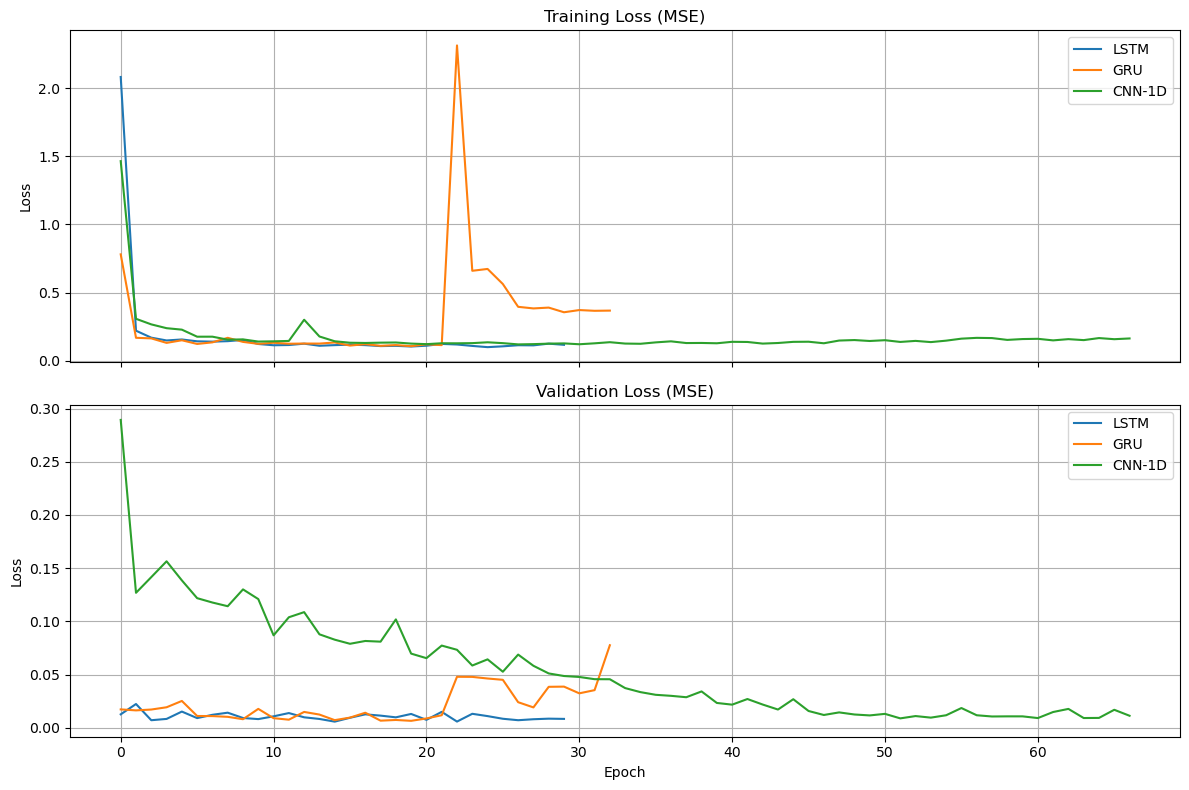

In [33]:
def extract_epoch_losses(training_log):
    epoch_losses = {}
    for entry in training_log:
        match = re.search(r"Epoch (\d+) Step \d+ - Loss: ([\d.]+)", entry)
        if match:
            epoch = int(match.group(1))
            loss = float(match.group(2))
            epoch_losses.setdefault(epoch, []).append(loss)
    avg_loss_per_epoch = [sum(losses)/len(losses) for epoch, losses in sorted(epoch_losses.items())]
    return avg_loss_per_epoch

paths = {
    'LSTM': './experiments/lstm/v3/results.json',
    'GRU': './experiments/gru/v5/results.json',
    'CNN-1D': './experiments/cnn/v3/results.json',
}

histories = {}
for model_name, path in paths.items():
    with open(path, 'r') as f:
        data = json.load(f)
        train_loss = extract_epoch_losses(data.get("training_log", []))
        val_loss = data.get("validation_loss_per_epoch", [])
        histories[model_name] = {
            "train_loss": train_loss,
            "val_loss": val_loss
        }

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

for model_name, history in histories.items():
    axes[0].plot(history["train_loss"], label=f'{model_name}')
    axes[1].plot(history["val_loss"], label=f'{model_name}')

axes[0].set_title("Training Loss (MSE)")
axes[1].set_title("Validation Loss (MSE)")

for ax in axes:
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

axes[1].set_xlabel("Epoch")

plt.tight_layout()
plt.savefig("learning_curves.png")
plt.show()

## Conclusioni